In [1]:
# All imports/seeds
import torch
from torch import nn
import torch.nn.functional as F

from model.mlp import MLP
from dataloader.utils import get_val_test_ids
from personal_utils import  (get_models_and_files, get_dataloaders_and_datasets,
                             get_embedding_files, send_through_model, send_through_patch_model,
                             send_through_decoder, generate_saliency_map, plot_saliency_map, alter_q_data, plot_reconstruction_difference)
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [2]:
from model.vq_vae import VectorQuantizedVAE
from model.vq_vae_patch_embedd import VQVAEPatch

_, _, _, train_data, val_data, test_data, train_labels, val_labels, test_labels = get_dataloaders_and_datasets()
vqvae_v1_files = dict(model='VQ-VAE-asimow-best.ckpt', mlp='my_trained_mlp.ckpt', q_emb='q_emb_v1.npy', q_ind='q_ind_v1.npy', type='VQ-VAE')
patch_vqvae_v1_files = dict(model='VQ-VAE-Patch-best-v1.ckpt', mlp='my_trained_mlp_on_patch_v1.ckpt', q_emb='patch_q_emb_v1.npy', q_ind='patch_q_ind_v1.npy', type='VQ-VAE-Patch')
patch_vqvae_v2_files = dict(model='VQ-VAE-Patch-best-v2.ckpt', mlp='my_trained_mlp_on_patch_v2.ckpt', q_emb='patch_q_emb_v2.npy', q_ind='patch_q_ind_v2.npy', type='VQ-VAE-Patch')
patch_vqvae_v4_files = dict(model='VQ-VAE-Patch-best-v4.ckpt', mlp='my_trained_mlp_on_patch_v4.ckpt', q_emb='patch_q_emb_v4.npy', q_ind='patch_q_ind_v4.npy', type='VQ-VAE-Patch')
patch_vqvae_v5_files = dict(model='VQ-VAE-Patch-best-v5.ckpt', mlp='my_trained_mlp_on_patch_v5.ckpt', q_emb='patch_q_emb_v5.npy', q_ind='patch_q_ind_v5.npy', type='VQ-VAE-Patch')
y_patch_vqvae_files = dict(model='Y-VQ-VAE-Patch-best.ckpt', mlp='my_trained_mlp_on_y_patch.ckpt', q_emb='y_patch_q_emb.npy', q_ind='y_patch_q_ind.npy', type='VQ-VAE-Patch')

def get_files_and_models(files: dict):
    # extract file paths from files dict
    model_path = f"./model_checkpoints/{files['type']}/{files['model']}"
    mlp_path = f"./MLPs/{files['mlp']}"
    q_emb_path = f"./created_files/{files['q_emb']}"
    q_ind_path = f"./created_files/{files['q_ind']}"

    # load model
    model_dict = torch.load(model_path, map_location=torch.device('cpu'))
    hparams = model_dict['hyper_parameters']
    if files['type']=='VQ-VAE':
        # hparams.pop('logger')
        model = VectorQuantizedVAE(**hparams)
        model.load_state_dict(model_dict['state_dict'])

    elif files['type']=='VQ-VAE-Patch':
        if 'use_improved_vq' not in hparams: hparams['use_improved_vq'] = None
        model = VQVAEPatch(**hparams)
        model.load_state_dict(model_dict['state_dict'])
    model.eval()

    # load mlp
    my_mlp = MLP(input_size=model.enc_out_len, output_size=2, in_dim=model.embedding_dim, hidden_sizes=512)
    my_mlp.load_state_dict(torch.load(mlp_path))
    my_mlp.eval()

    # extract codebook and load quantized embeddings
    if files['type']=='VQ-VAE-Patch' and hparams["use_improved_vq"]:
        codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
    q_emb = torch.round(torch.tensor(np.load(q_emb_path), dtype=torch.float32), decimals=3)
    q_ind = np.load(q_ind_path)
    return dict(model=model, mlp=my_mlp, codebook=codebook, q_emb=q_emb, q_ind=q_ind, hparams=hparams, type=files['type'])

# get dicts for every trained model combination containing model, mlp, codebook, q_emb, q_ind, hparams, type (VQ-VAE or VQ-VAE-Patch)
vqvae_v1 = get_files_and_models(vqvae_v1_files)
patch_vqvae_v1 = get_files_and_models(patch_vqvae_v1_files)
patch_vqvae_v2 = get_files_and_models(patch_vqvae_v2_files)
patch_vqvae_v4 = get_files_and_models(patch_vqvae_v4_files)
patch_vqvae_v5 = get_files_and_models(patch_vqvae_v5_files)
y_patch_vqvae = get_files_and_models(y_patch_vqvae_files)


In [3]:
patch_vqvae_v1["hparams"]

{'hidden_dim': 256,
 'input_dim': 2,
 'num_embeddings': 256,
 'embedding_dim': 16,
 'n_resblocks': 8,
 'learning_rate': 0.001,
 'seq_len': 200,
 'dropout_p': 0.1,
 'patch_size': 25,
 'batch_norm': False,
 'beta': 0.25,
 'use_improved_vq': True,
 'kmeans_iters': 10,
 'threshold_ema_dead_code': 2}

In [24]:
def send_through_patch_decoder(q_data, model, original_data):
    with torch.no_grad():
        x_hat = model.decoder(q_data.permute(0, 2, 1))
        x_hat = model.reverse_patch_embed(x_hat)
        print(x_hat.shape)
        print(original_data.shape)
        recon_error = F.mse_loss(x_hat, original_data.unsqueeze(0))
    return  x_hat, recon_error

[ 33 141 224 116  10 112   5  83  33 247   8  10  17  60  60  60]
torch.Size([1, 200, 2])
torch.Size([200, 2])
torch.Size([1, 200, 2])
torch.Size([200, 2])
Test Shape  torch.Size([200, 2])


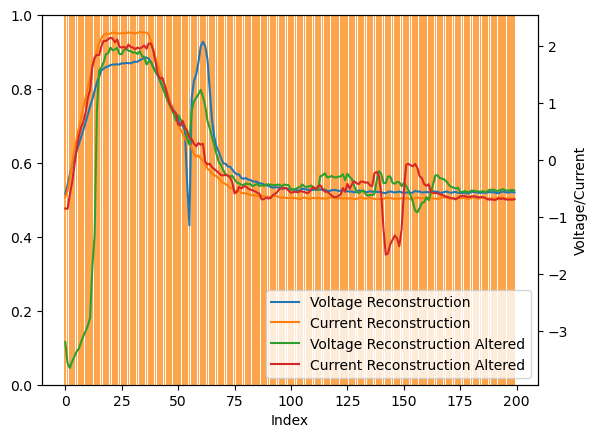

tensor([2.7947, 3.4394, 3.6724, 3.7661, 3.7348, 3.6927, 3.7286, 3.7499, 3.8660,
        3.9223, 3.8894, 3.9259, 2.9501, 2.5459, 0.5659, 0.3095, 0.1893, 0.2081,
        0.3609, 0.3153, 0.3827, 0.3556, 0.4243, 0.3944, 0.4150, 0.4102, 0.4756,
        0.5156, 0.4317, 0.4607, 0.4152, 0.4444, 0.3882, 0.4479, 0.3169, 0.2328,
        0.4088, 0.1885, 0.0557, 0.0342, 0.0773, 0.1636, 0.1353, 0.0203, 0.0147,
        0.0674, 0.1484, 0.1030, 0.0748, 0.1889, 0.0879, 0.1877, 0.2668, 0.2563,
        0.9796, 1.4917, 0.3796, 0.5376, 0.5936, 0.7769, 1.0025, 1.2522, 1.0929,
        1.1502, 0.7921, 0.4048, 0.2571, 0.2149, 0.2808, 0.2248, 0.2519, 0.3438,
        0.3367, 0.3603, 0.2082, 0.1665, 0.1527, 0.2243, 0.1922, 0.2300, 0.2146,
        0.1803, 0.1597, 0.1732, 0.1279, 0.0879, 0.0951, 0.0965, 0.0698, 0.0406,
        0.0451, 0.0632, 0.0501, 0.0764, 0.1278, 0.2042, 0.2067, 0.2359, 0.2324,
        0.1965, 0.0980, 0.1153, 0.1135, 0.1641, 0.1947, 0.1863, 0.1455, 0.1331,
        0.1772, 0.2511, 0.2267, 0.1673, 

In [32]:
def plot_reconstruction_difference_v2(reconstructed_original, reconstructed_changed, original, label, plot_original=False):
    difference = torch.sum(torch.abs(reconstructed_original - reconstructed_changed), dim=1)
    difference_extreme = torch.where(difference > 0, 1.0, 0.0).clone().detach()
    colormap = plt.colormaps['Wistia']
    fig, ax = plt.subplots()
    # fig.set_size_inches(12, 7)
    ax2 = ax.twinx()
    bars = ax.bar(np.arange(len(reconstructed_original)), [1] * len(reconstructed_original), color=colormap(difference_extreme), alpha=0.7)
    # colormap = plt.colormaps['binary']
    # bars_impact = ax.bar([0,83,93,195], [1] * 4, color=colormap(np.ones(shape = (4,))), alpha=1)
    # bars_impact = ax.bar([28,60,140, 172], [1] * 4, color=colormap(np.ones(shape = (4,))), alpha=1)
    # ax.plot(difference, color='black', linewidth=2)
    ax.set_ylim(0, 1)
    # ax2.set_ylim(-5, 5)
    ax.set_xlabel('Index')
    # ax.set_ylabel('Difference')
    ax2.set_ylabel('Voltage/Current')
    ax2.plot(reconstructed_original)
    # ax.plot(reconstructed_original)

    # add legend with Voltage and Current

    ax2.plot(reconstructed_changed)
    # label fig
    ax2.legend(['Voltage Reconstruction', 'Current Reconstruction', 'Voltage Reconstruction Altered', 'Current Reconstruction Altered'], loc='lower right')

    # ax.set_title(f'Difference between Original and Changed Reconstruction for {label}')
    # if plot_original: ax2.plot(original)
    plt.show()
    return difference

def plot_reconstruction_difference_multiple_next_to_each_other(reconstructed_original, reconstructed_changed, original, label, plot_original=False, x_counter=0, value=0.0):
    difference = torch.sum(torch.abs(reconstructed_original - reconstructed_changed), dim=1)
    difference_extreme = torch.where(difference > 0, 1.0, 0.0).clone().detach()
    colormap = plt.colormaps['Wistia']
    # fig, ax = plt.subplots()
    ax[x_counter].set_xlabel('Index')
    # ax.set_ylabel('Difference')
    ax[x_counter].set_ylabel('Voltage/Current')
    ax[x_counter].plot(reconstructed_original)
    ax[x_counter].plot(reconstructed_changed)
    # label fig
    ax[x_counter].set_title(f'each 2nd embedding dimension value set to {value}')

    ax[x_counter].legend(['Voltage Reconstruction', 'Current Reconstruction', 'Voltage Reconstruction Altered', 'Current Reconstruction Altered'], loc='lower right')
    # plt.show()
    return difference

def alter_q_data_v2(model_dict, test_dpt, original_data, alter_range, alter_embedding, plot_original=False, patch=False):
    q_emb = model_dict["q_emb"][test_dpt]
    q_ind = model_dict["q_ind"][test_dpt]
    model = model_dict["model"]
    model_hparams = model_dict["hparams"]
    label = model_dict["type"]

    if 'use_improved_vq' not in model_hparams: model_hparams['use_improved_vq'] = None
    if model_hparams["use_improved_vq"]:
        # codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
        codebook = model.vector_quantization.vq.codebooks[0]
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
        # codebook = model.vector_quantization.embedding.weight.data

    changed_q_data = q_emb.clone().detach()
    changed_q_indices = q_ind.copy()
    # for p in range(2):
    # test_embeds = [221, 85, 134, 214]
    # test_embeds_2 = [47, 49, 207, 207, 207, 149, 251, 87, 88, 116]
    # test_embeds_3 = [207, 207, 149, 251, 87, 88, 116, 151]
    # test_embeds_4 = [49, 207, 207, 207, 149, 251, 87, 88, 116, 151]
    for j,i in enumerate(alter_range):
        # alter_embedding = test_embeds[j]
        changed_q_indices[i] = alter_embedding
        # altered_data = q_emb[i].clone()
        # valuess = [0.0, -2.1350, 2.4010]
        # altered_data[0:32:2] = valuess[1]
        # altered_data[0:32:2] = -2.1350
        # altered_data[0:32:2] = 2.4010
        # altered_data[:] = 2.4010
        # altered_data[:16] = -2.1350
        changed_q_data[i] = codebook[alter_embedding] 
        # changed_q_data[i] = altered_data
        if label=='VQ-VAE-Patch':
            changed_q_indices[i+8] = alter_embedding
            changed_q_data[i+8] = codebook[alter_embedding] 
    print(changed_q_indices)
    if patch:
        reconstructed_original, _= send_through_patch_decoder(q_data=q_emb.unsqueeze(0), model=model, original_data = original_data)
        reconstructed_changed, _= send_through_patch_decoder(q_data=changed_q_data.unsqueeze(0), model=model, original_data = original_data)
    else:
        reconstructed_original, _= send_through_decoder(model=model, q_data=q_emb.unsqueeze(0), original_data = original_data, label=label)
        reconstructed_changed, _= send_through_decoder(model=model, q_data=changed_q_data.unsqueeze(0), original_data = original_data, label=label)
    print(f"Test Shape ", original_data.shape)
    difference = plot_reconstruction_difference_v2(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=original_data, label=label, plot_original=plot_original)
    print(difference)
    # difference = plot_reconstruction_difference_multiple_next_to_each_other(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=original_data, label=label, plot_original=plot_original, x_counter=p, value=valuess[p])
    # partial_difference = torch.sum(torch.abs(reconstructed_original[0][5:84] - reconstructed_changed[0][117:196]), dim=1)
    # print(partial_difference)
    # count 0.000s in partial difference
    # print(len(np.where(partial_difference == 0)[0]))

    return changed_q_data, changed_q_indices, difference

test_dpt = 3
original_data =torch.tensor(train_data[test_dpt])

current_model = patch_vqvae_v1
# fig, ax = plt.subplots(1,2)
# fig.set_size_inches(14, 5)
counter = 0
# ax.plot(original_data)
# create empty tensor for summing up differencs
all_differences = torch.zeros(200)

# for i in range(0,24):
changed_q_data, changed_q_indices, difference = alter_q_data_v2(current_model, test_dpt, original_data, range(0, 1), 33, patch=True)
# print("Originl Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])
# my_difference = np.where(difference > 0)[0]
# if len(my_difference) > 0:
#     print(np.where(difference > 0)[0][0], np.where(difference > 0)[0][-1])
#     print("Amount of Differences: ", len(np.where(difference > 0)[0]))
# else:
#     print("No Differences for ", i)
# all_differences += difference
# print(my_difference)
# ax.plot(all_differences, color='black', linewidth=2)
colormap = plt.colormaps['Wistia']
# print(min(all_differences), max(all_differences))

# scale data
denominator = max(all_differences) - 0
scaled_data = [(datum-min(all_differences))/denominator for datum in all_differences]

print("Originl Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])
print("Changed Q-Embeddings Indices: ", changed_q_indices)
print("Total Differences: ", torch.sum(difference))


### Inputwise Alteration
Changing every second value to 0.0000
- Total Differences: 98.1721
- Current: 50.2132
- Voltage: 47.9589

Changin every second value to -2.1350
- Total Differences: 298.4066
- Current: 112.5607
- Voltage: 185.8459

Changing nothing
- Total Differences: 16.8694
- Current: 10.2924
- Voltage: 6.5770

In [185]:
print(current_model["codebook"].max())
print(current_model["codebook"].min())
print(current_model["codebook"].mean())
print(current_model["q_emb"].max())
print(current_model["q_emb"].min())
# print the max value of every dimension among all q-embeddings without sorting it
# print(current_model["codebook"].max(dim=0))
# print(current_model["codebook"].min(dim=0))
# print(current_model["codebook"].mean(dim=0).float())
print(current_model["codebook"][207])
# create a tensor with 32 values of 0.0
zeros_t = torch.zeros(32)
# create a tensor with 32 values of 0.1
ones_t = torch.ones(32) * 0.1

difference =current_model["codebook"][207] - ones_t
print(difference.sum())

tensor(2.4010)
tensor(-2.1350)
tensor(0.0005)
tensor(2.4010)
tensor(-2.1350)
tensor([ 0.1480,  0.1030,  0.9970,  1.3250,  0.0600, -0.1840, -0.9430,  0.0470,
        -1.5640,  0.4410, -0.4960,  1.3880, -1.3740,  0.6360, -0.7900, -1.2760,
        -0.9160, -0.0990, -0.0160, -1.0270, -0.7280,  0.1210,  0.3570,  0.2760,
        -0.1060,  0.6460,  0.4080, -0.5850,  0.2700, -1.2600,  0.1250,  0.2990])
tensor(-6.9170)


[ 77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199]
77 199
Amount of Differences:  123
Q Indices before:  [ 47  49 207 207 207 149 251  87  88 116 151 214 214 133 133 133 133 133
 133 133 133 133 133 133 133  98]
Q Indices after:  [ 47  49 207 207 207 149 251  87  88 116 151 214   3 154 207 207 207 149
 251  87  88 116 151 214 214  98]


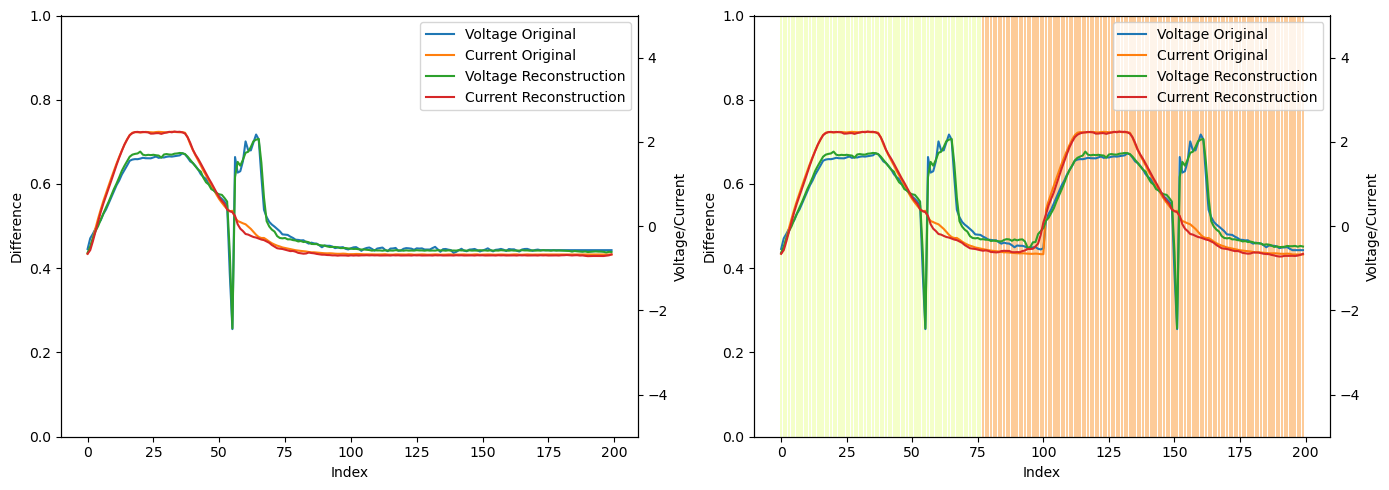

In [5]:
def plot_reconstruction_difference_v3(reconstructed_original, reconstructed_changed, original, label, plot_original=False, column_plot=0):
    difference = torch.sum(torch.abs(reconstructed_original - reconstructed_changed), dim=1)
    difference_extreme = torch.where(difference > 0, 1.0, 0.0).clone().detach()
    colormap = plt.colormaps['Wistia']
    # fig, ax = plt.subplots()
    # fig.set_size_inches(12, 7)
    ax2 = ax[column_plot].twinx()
    if plot_original: ax2.plot(original)
    if column_plot ==1:bars = ax[column_plot].bar(np.arange(len(reconstructed_original)), [1] * len(reconstructed_original), color=colormap(difference_extreme), alpha=0.4)
    # ax.plot(difference, color='black', linewidth=0.5)
    ax[column_plot].set_ylim(0, 1)
    ax2.set_ylim(-5, 5)
    ax[column_plot].set_xlabel('Index')
    ax[column_plot].set_ylabel('Difference')
    ax2.set_ylabel('Voltage/Current')
    ax2.plot(original)
    if column_plot == 0:
        ax2.plot(reconstructed_original)
    else:
        ax2.plot(reconstructed_changed)
    # label fig
    # ax.set_title(f'Difference between Original and Changed Reconstruction for {label}')
    
    # add legend to plot
    ax2.legend(['Voltage Original', 'Current Original', 'Voltage Reconstruction', 'Current Reconstruction'], loc='upper right')
    # plt.show()
    return difference

def alter_input_data(original_data, alter_slice, alter_value, model, label, plot_altered=False, write_csv=False):
    altered_input = original_data.clone()
    # altered_input[alter_slice]=torch.tensor([alter_value, alter_value])
    altered_input[101:195] = original_data[5:99]
    # print(altered_input)
    if label == "VQ-VAE":
        _, _, _, q_data, q_indices, _, _ = send_through_model(model, original_data.unsqueeze(0), reconstruct=False)
        _, _, _, changed_q_data, changed_q_indices, _, _ = send_through_model(model, altered_input.unsqueeze(0), reconstruct=False)
    else:
        _, _, _, q_data, q_indices, _, _ = send_through_patch_model(model, original_data.unsqueeze(0), reconstruct=False)
        _, _, _, changed_q_data, changed_q_indices, _, _ = send_through_patch_model(model, altered_input.unsqueeze(0), reconstruct=False)

    # correcr dimensions, so that its always [enc_out_len, 1], because Residual VQ returns Indices in 3 dimensions (num_quantizers, enc_out_len, 1)

    q_indices = q_indices.reshape(-1).unsqueeze(1)
    changed_q_indices = changed_q_indices.reshape(-1).unsqueeze(1)
    changed_q_data = torch.round(changed_q_data, decimals=3)
    q_data = torch.round(q_data, decimals=3)
    reconstructed_original, _= send_through_decoder(model=model, q_data=q_data, original_data = original_data, label=label)
    reconstructed_changed, _= send_through_decoder(model=model, q_data=changed_q_data, original_data = original_data, label=label)
    original_data_list = [original_data, altered_input]
    for i in range(2):
        if  not write_csv: difference = plot_reconstruction_difference_v3(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=original_data_list[i], label=label, plot_original=plot_altered, column_plot=i)
    difference = torch.sum(torch.abs(reconstructed_original[0] - reconstructed_changed[0]), dim=1)

    difference_indices = np.where(difference > 0)[0]
    # print(difference[difference_indices])
    print(difference_indices)
    first_difference = None
    last_difference = None
    if len(difference_indices) > 0:
        print(difference_indices[0], difference_indices[-1])
        first_difference = difference_indices[0]
        last_difference = difference_indices[-1]
        print("Amount of Differences: ", len(difference_indices))
    else:
        print("No Differences for ", i)

    print("Q Indices before: ", np.array(q_indices).reshape(q_indices.shape[0],))
    print("Q Indices after: ", np.array(changed_q_indices).reshape(q_indices.shape[0],))
    similarity = np.array(q_indices==changed_q_indices).reshape(26,)
    different_indices = q_indices[~similarity].numpy().reshape(-1)
    different_changed_indices = changed_q_indices[~similarity].numpy().reshape(-1)
    # print(similarity)
    # print(np.where(similarity==False))
    # print("")
    # ergebnis_schreiben([alter_slice, original_data[alter_slice], altered_input[alter_slice], np.where(similarity==False), len(np.where(similarity==False)[0]), str(str(difference_indices[0]) + "-" + str(difference_indices[-1])), ""])
    ergebnis_schreiben([alter_slice, alter_value, np.where(similarity==False)[0], different_indices, different_changed_indices, len(np.where(similarity==False)[0]), str(str(first_difference) + "-" + str(last_difference)), len(difference_indices)])
    return changed_q_data, changed_q_indices
test_dpt = 3
original_data = torch.from_numpy(train_data[test_dpt]).float()

fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 5)


import csv
csvfile = open('result_input_altering.csv', 'w', newline='')
writer = csv.writer(csvfile)
writer.writerow(["Changed Input Range", "New Value", "Affected Embeddings", "Original Embeddings", "New Embeddings", "Amount Affected Embeddings", "Affected Reconstruction Range", "Affected Reconstruction Datapoints"])   
csvfile.close()

def ergebnis_schreiben(my_row):
    csvfile = open('result_input_altering.csv', 'a', newline='')
    writer = csv.writer(csvfile)
    writer.writerow(my_row)   
    csvfile.close()


current_model = get_files_and_models(vqvae_v1_files)
step = 100
# for i in range(100,200-step+1, step):
i_changed_q_data, i_changed_q_indices = alter_input_data(original_data=original_data, alter_slice=slice(100, 110),
                                                            alter_value=4, model=current_model["model"], label="VQ-VAE",
                                                            plot_altered=False, write_csv=False)

plt.tight_layout()
plt.show()

In [136]:
def send_through_model(model, input_data, reconstruct=True):
    with torch.no_grad():
        print(input_data.shape)
        permuted_original = input_data.permute(0, 2, 1)
        print(permuted_original.shape)
        z_e = model.encoder(permuted_original)
        print(z_e.shape)
        encoded_data = z_e.permute(0,2,1)
        print(encoded_data.shape)
        embedding_loss, quantized_data, perplexity, _, q_indices = model.vector_quantization(encoded_data)
        print(quantized_data.shape)

        z_q = quantized_data.permute(0,2,1)
        print(z_q.shape)

        if model.decoder_type == "Linear":
            z_q = z_q.reshape(z_q.shape[0], z_q.shape[1] * z_q.shape[2])
        x_hat = None
        recon_error = None
        loss = None
        if reconstruct:
            x_hat = model.decoder(z_q)
            print(x_hat.shape)
            if model.decoder_type == "Conv":
                x_hat = x_hat.permute(0, 2, 1)
            recon_error = F.mse_loss(x_hat, input_data)
            loss = recon_error + embedding_loss
    return embedding_loss, x_hat, perplexity, quantized_data, q_indices, recon_error, loss


test_dpt = 5
original_data = torch.from_numpy(train_data[test_dpt]).float()
_,_,perplexity,_,q_indices,_,_ =send_through_model(current_model["model"], original_data.unsqueeze(0), reconstruct=True)
# q_indices

torch.Size([1, 200, 2])
torch.Size([1, 2, 200])
torch.Size([1, 32, 26])
torch.Size([1, 26, 32])
torch.Size([1, 26, 32])
torch.Size([1, 32, 26])
torch.Size([1, 2, 200])


In [1]:
def compute_out_len(seq_len, k_1=7, k_2=5, k_3=3, s_1=2, s_2=2, s_3=2, p_1=3, p_2=2, p_3=2):
    # out_len_1 = (seq_len + 2 * p_1 - k_1) // s_1 + 1
    out_len_1 = (200 + 2 * 3 - 7) // 2 + 1
    print(out_len_1)
    # out_len_2 = (out_len_1 + 2 * p_2 - k_2) // s_2 + 1
    out_len_2 = (100 + 2 * 2 - 5) // 2 + 1
    print(out_len_2)
    # out_len_3 = (out_len_2 + 2 * p_3 - k_3) // s_3 + 1
    out_len_3 = (50 + 2 * 2 - 3) // 2 + 1
    print(out_len_3)
    # return out_len_3

compute_out_len(200)

100
50
26


In [7]:
class ResBlock(nn.Module):
    def __init__(self, dim, dropout_p=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.GELU(),
            nn.Conv1d(dim, dim, 3, 1, 1),
            nn.BatchNorm1d(dim),
            nn.GELU(),
            nn.Conv1d(dim, dim, 1),
            nn.BatchNorm1d(dim),
            nn.Dropout(p=dropout_p)
        )

    def forward(self, x):
        return x + self.block(x)

In [6]:
# model hparams
current_model["hparams"]

{'logger': <lightning.pytorch.loggers.csv_logs.CSVLogger at 0x7f7b7ebcf6d0>,
 'hidden_dim': 32,
 'input_dim': 2,
 'num_embeddings': 256,
 'embedding_dim': 32,
 'n_resblocks': 1,
 'learning_rate': 0.001,
 'seq_len': 200,
 'dropout_p': 0.1,
 'decoder_type': 'Conv'}

In [23]:
m = nn.Conv1d(2, 32, kernel_size=7, stride=2, padding=3)
m2 = nn.BatchNorm1d(32)
m3 = nn.GELU()
m4 = nn.Conv1d(32, 32, kernel_size=5, stride=2, padding=2)
m5 = ResBlock(32, dropout_p=0.1)
input = torch.randn(1, 2, 200)
a = m(input)
print(a.shape)
b = m2(a)
print(b.shape)
c = m3(b)
print(c.shape)
d = m4(c)
print(d.shape)
e = m5(d)
print(e.shape)

torch.Size([1, 32, 100])
torch.Size([1, 32, 100])
torch.Size([1, 32, 100])
torch.Size([1, 32, 50])
torch.Size([1, 32, 50])


In [160]:
m = nn.ConvTranspose1d(32, 32, kernel_size=3, stride=2, padding=2, output_padding=1)
m2 = ResBlock(32, dropout_p=0.1)
m3 = nn.GELU()
m4 = nn.ConvTranspose1d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
m5 = nn.BatchNorm1d(32)
m6 = nn.GELU()
m7 = nn.ConvTranspose1d(32, 2, kernel_size=7, stride=2, padding=3, output_padding=1)


In [201]:
input = torch.zeros(1, 32, 26)
input[0][:][0] = torch.ones(26)
print(input[0][:][0].shape)
a = m(input)
# print(a[0][:][0])
b = m2(a)
print(b.shape)
c = m3(b)
print(c.shape)
d = m4(c)
print(d.shape)
e = m5(d)
print(e.shape)
f = m6(e)
print(f.shape)
g = m7(f)
# print(g[0])


torch.Size([26])
torch.Size([1, 32, 50])
torch.Size([1, 32, 50])
torch.Size([1, 32, 100])
torch.Size([1, 32, 100])
torch.Size([1, 32, 100])


In [252]:
my_decoder = current_model["model"].decoder
input = torch.zeros(1, 32, 26)
print(my_decoder(input)[0][1][:20])
altered_input = input.clone()
altered_input[0,:,0] = 1.0
print(my_decoder(altered_input)[0][1][:20])
print(my_decoder(input)[0][1] == my_decoder(altered_input)[0][1])
print(my_decoder(input)[0][0] == my_decoder(altered_input)[0][0])

tensor([-0.5664, -0.5906, -0.4853, -0.4876, -0.4447, -0.4637, -0.4363, -0.4324,
        -0.3748, -0.4199, -0.4190, -0.4203, -0.3748, -0.4199, -0.4190, -0.4203,
        -0.3748, -0.4199, -0.4190, -0.4203], grad_fn=<SliceBackward0>)
tensor([-0.5174, -0.5200, -0.3717, -0.3612, -0.2769, -0.3319, -0.3215, -0.3322,
        -0.3298, -0.3845, -0.3931, -0.4017, -0.3748, -0.4199, -0.4190, -0.4203,
        -0.3748, -0.4199, -0.4190, -0.4203], grad_fn=<SliceBackward0>)
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,

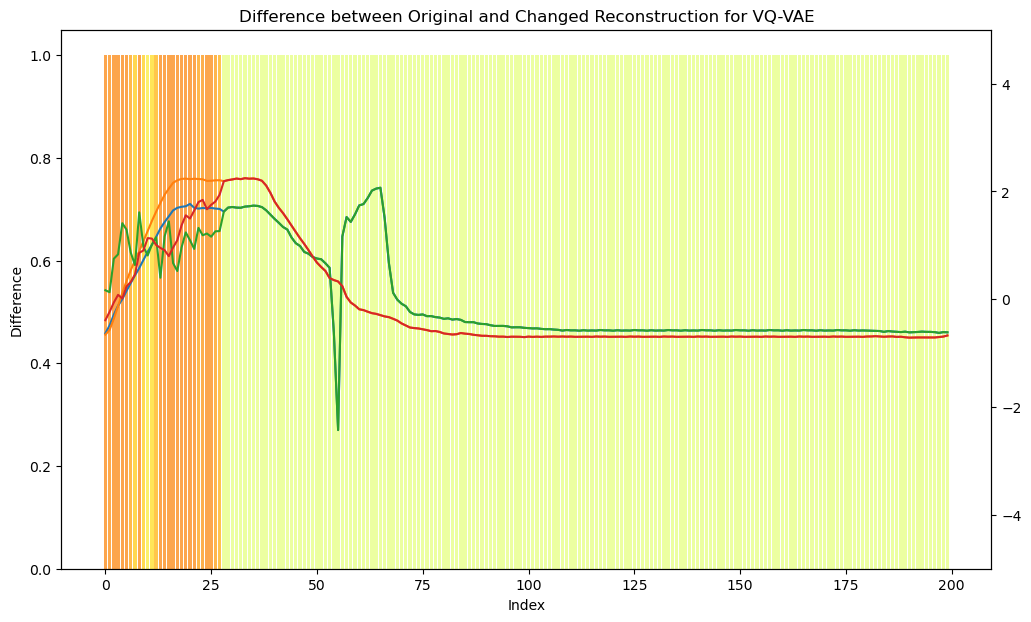

0 27
Amount of Differences:  28
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Originl Q-Embeddings Indices:  [ 47  49 207 207 207 149 251  87  88 116 151 214 214 133 133 133 133 133
 133 133 133 133 133 133 133  98]


In [109]:
def plot_reconstruction_difference_v2(reconstructed_original, reconstructed_changed, original, label, plot_original=False):
    difference = torch.sum(torch.abs(reconstructed_original - reconstructed_changed), dim=1)
    colormap = plt.colormaps['Wistia']
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 7)
    ax2 = ax.twinx()
    bars = ax.bar(np.arange(len(reconstructed_original)), [1] * len(reconstructed_original), color=colormap(difference), alpha=0.7)
    # ax.plot(difference, color='black', linewidth=2)
    # ax.set_ylim(0, 1)
    ax2.set_ylim(-5, 5)
    ax.set_xlabel('Index')
    ax.set_ylabel('Difference')
    ax2.plot(reconstructed_original)
    ax2.plot(reconstructed_changed)
    # label fig
    ax.set_title(f'Difference between Original and Changed Reconstruction for {label}')
    if plot_original: ax2.plot(original)
    plt.show()
    return difference

def alter_q_data_v3(model_dict, test_dpt, original_data, alter_range, alter_slice, alter_value, plot_original=False):
    q_emb = model_dict["q_emb"][test_dpt]
    q_ind = model_dict["q_ind"][test_dpt]
    model = model_dict["model"]
    model_hparams = model_dict["hparams"]
    label = model_dict["type"]

    if 'use_improved_vq' not in model_hparams: model_hparams['use_improved_vq'] = None
    if model_hparams["use_improved_vq"]:
        codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)

    changed_q_data = q_emb.clone().detach()
    changed_q_indices = q_ind.copy()

    for i in alter_range:
        changed_q_data[i][alter_slice] = alter_value
        # changed_q_data[i] = codebook[alter_value] 
        if label=='VQ-VAE-Patch':
            changed_q_indices[i+8] = alter_value
            changed_q_data[i+8] = codebook[alter_value] 

    reconstructed_original, _= send_through_decoder(model=model, q_data=q_emb.unsqueeze(0), original_data = original_data, label=label)
    reconstructed_changed, _= send_through_decoder(model=model, q_data=changed_q_data.unsqueeze(0), original_data = original_data, label=label)
    difference = plot_reconstruction_difference_v2(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=original_data, label=label, plot_original=plot_original)
    return changed_q_data, changed_q_indices, difference

test_dpt = 3
original_data =torch.tensor(train_data[test_dpt])

current_model = get_files_and_models(vqvae_v1_files)
# fig, ax = plt.subplots()

# create empty tensor for summing up differencs
all_differences = torch.zeros(200)

# for i in range(0,24):
changed_q_data, changed_q_indices, difference = alter_q_data_v3(current_model, test_dpt, original_data, range(0,3), slice(0,16), -2.4)
# print("Originl Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])
# print("Changed Q-Embeddings Indices: ", changed_q_indices)
my_difference = np.where(difference > 0)[0]
if len(my_difference) > 0:
    print(np.where(difference > 0)[0][0], np.where(difference > 0)[0][-1])
    print("Amount of Differences: ", len(np.where(difference > 0)[0]))
else:
    print("No Differences for ", i)
all_differences += difference
print(my_difference)
# ax.plot(all_differences, color='black', linewidth=2)
colormap = plt.colormaps['Wistia']
# print(min(all_differences), max(all_differences))

# scale data
denominator = max(all_differences) - 0
scaled_data = [(datum-min(all_differences))/denominator for datum in all_differences]

# bars = ax.bar(np.arange(len(original_data)), [1] * len(original_data), color=colormap(scaled_data), alpha=1)
# plt.show()

print("Originl Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])

# UMAP Experiments

In [77]:
patch_vqvae_v1["q_ind"][0]

array([ 37,  24, 178, 131,  10,   5, 238, 211,  31, 181, 178,  10,  17,
        60,  60,  19])

In [84]:
current_model["q_ind"][:,8:]

array([[ 31, 181, 178, ...,  60,  60,  19],
       [139, 152, 246, ...,  55,  55,  55],
       [ 31, 188, 119, ...,  60,  60,  60],
       ...,
       [157, 247, 246, ...,  83,  83,  83],
       [196, 114, 205, ..., 250, 250, 250],
       [  6, 152, 246, ..., 162, 162, 162]])

There are  256  unique codebook embeddings used to represent the data
There are  256  unique codebook embeddings used to represent voltage
There are  154  unique codebook embeddings used to represent current
(154, 2)


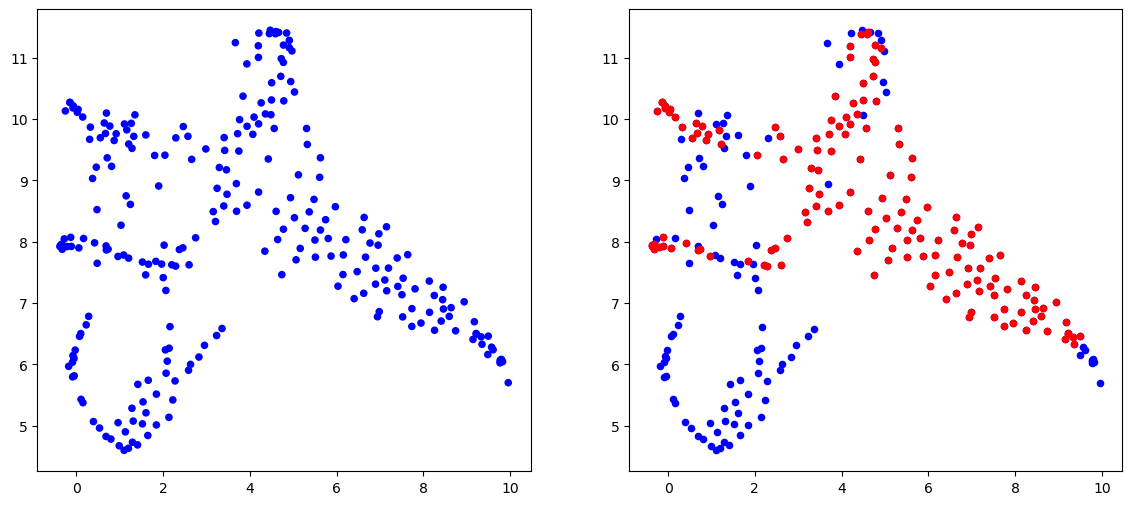

In [93]:
import umap
# current_model = get_files_and_models(vqvae_v1_files)
current_model = get_files_and_models(patch_vqvae_v1_files)
codebook = current_model["codebook"]
# reducer = umap.UMAP(verbose=True, random_state=42)
# reducer.fit_transform(codebook)

# with open('umap_reducer_patch_v4.pkl', 'wb') as f:
#     pickle.dump(reducer, f)
# with open('umap_reducer.pkl', 'rb') as f:
#     loaded_reducer = pickle.load(f)
with open('umap_reducer_patch_v1.pkl', 'rb') as f:
    loaded_reducer = pickle.load(f)


codebook_umap = loaded_reducer.transform(codebook)
# plt.scatter(codebook_umap[:, 0], codebook_umap[:, 1])

# Q Indices before:  [ 47  49 207 207 207 149 251  87  88 116 151 214 214 133 133 133 133 133
#  133 133 133 133 133 133 133  98]
# Q Indices after:  [ 47  49 207 207 207 149 251  87  88 116 151 214 222  21 149 207 207 207
#  149 144 209 225 153   3 214  98]


unique, counts = np.unique(current_model["q_ind"][:,:], return_counts=True)
print("There are ", len(unique), " unique codebook embeddings used to represent the data")
unique_voltage, counts_voltage = np.unique(current_model["q_ind"][:,:8], return_counts=True)
print("There are ", len(unique_voltage), " unique codebook embeddings used to represent voltage")
unique_current, counts_current = np.unique(current_model["q_ind"][:,8:], return_counts=True)
print("There are ", len(unique_current), " unique codebook embeddings used to represent current")

# print(unique_current)
print(codebook_umap[unique_current].shape)

color_array = np.full((256, ), 'b')
# for i in unique[np.argsort(counts)][-200:]:
#     color_array[i] = 'r'
# for i in [222, 21, 149, 207, 144, 209, 225, 153, 3, 214, 98]:
#     color_array[i] = 'r'
# for i in [47,  49, 207, 149, 251,  87,  88, 116, 151, 214]:
#     color_array[i] = 'y'
# for i in [225]:
#     color_array[i] = 'r'
# for i in [88]:
#     color_array[i] = 'g'
# for i in [4,   97,  221,  168]:
#     color_array[i] = 'y'

fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 6)

ax[0].scatter(codebook_umap[:, 0], codebook_umap[:, 1], c=color_array, s=20)
# for i in unique[np.argsort(counts)][-128:]:
#     color_array[i] = 'r'

ax[1].scatter(codebook_umap[unique_voltage, 0], codebook_umap[unique_voltage, 1], c="b", s=20)
ax[1].scatter(codebook_umap[unique_current, 0], codebook_umap[unique_current, 1], c="r", s=20)

# plt.scatter(codebook_umap[42, 0], codebook_umap[42, 1], c='r', s=20)

plt.show()


In [ ]:
from vector_quantize_pytorch import ResidualVQ



## Dataset Exploration

In [3]:
from dataloader.asimow_dataloader import DataSplitId, ASIMoWDataModule

data_dict = get_val_test_ids()
input_dim = 2


# load data
dataset_dict = get_val_test_ids()
val_ids = dataset_dict["val_ids"]
test_ids = dataset_dict["test_ids"]
val_ids = dataset_dict['val_ids']
test_ids = dataset_dict['test_ids']


val_ids = [DataSplitId(experiment=e, welding_run=w) for e, w in val_ids]
test_ids = [DataSplitId(experiment=e, welding_run=w) for e, w in test_ids]
data_module = ASIMoWDataModule(task="reconstruction", batch_size=128, n_cycles=1, val_data_ids=val_ids, test_data_ids=test_ids)
current_model = get_files_and_models(vqvae_v1_files)



In [93]:
def get_dataloaders_and_datasets_x():
    data_dict = get_val_test_ids()
    val_ids = data_dict["val_ids"]
    test_ids = data_dict["test_ids"]
    val_ids = [DataSplitId(experiment=item[0], welding_run=item[1])
                for item in val_ids]
    test_ids = [DataSplitId(experiment=item[0], welding_run=item[1])
                for item in test_ids]
    data_module = ASIMoWDataModule(task="classification", batch_size=128, n_cycles=1, val_data_ids=val_ids, test_data_ids=test_ids)

    data_module.setup('fit')

    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()
    test_loader = data_module.test_dataloader()

    train_data = train_loader.dataset.data
    val_data = val_loader.dataset.data
    test_data = test_loader.dataset.data

    train_labels, val_labels, test_labels = None, None, None
    # train_labels = train_loader.dataset.labels
    # val_labels = val_loader.dataset.labels
    # test_labels = test_loader.dataset.labels
    return train_loader, val_loader, test_loader, train_data, val_data, test_data, train_labels, val_labels, test_labels

train_loader, val_loader, test_loader, train_data, val_data, test_data, train_labels, val_labels, test_labels = get_dataloaders_and_datasets_x()

In [101]:
total_len = len(train_data)+len(val_data)+len(test_data)
print(total_len)
print(len(train_data)/total_len, len(val_data)/total_len, len(test_data)/total_len)

96408
0.7751638868143722 0.11474151522695213 0.11009459795867563


In [95]:
96408/209185

0.46087434567488106

In [5]:
data_module.setup(stage = "test")

In [98]:
train_data.shape

(74732, 200, 2)

In [107]:
data_module.train_dataloader().dataset

AttributeError: 'MyReconstructionDataset' object has no attribute 'label'

In [265]:
abc = data_module.asimow_dataloader.preprocessing(load_raw_data("data"))

In [ ]:
original_data = torch.from_numpy(train_data[0]).float()

In [92]:
train_data.shape

(162599, 200, 2)

In [111]:
print(len(abc[abc.labels==0]))
print(len(abc[abc.labels==1]))

49742
46666


In [294]:
abc[abc.labels != -1]

,t_wn,experiment,welding_run,labels,V,I
30,30,1,2,0,"[21.26093749659825, 23.799479162858752, 24.617...","[25.260416669900003, 47.460937506075, 83.91927..."
31,31,1,2,0,"[20.4614583300595, 22.168749996453, 23.5546874...","[22.9166666696, 36.653645838025, 69.5312500089..."
32,32,1,2,0,"[20.251041663426506, 21.924999996492, 23.26145...","[22.591145836225003, 30.924479170625, 61.32812..."
33,33,1,2,0,"[21.3156249965895, 23.57343749622825, 24.46770...","[25.455729169925, 47.916666672800005, 84.44010..."
34,34,1,2,0,"[20.41718749673325, 21.980729163149757, 23.447...","[23.437500003000004, 36.783854171375, 69.72656..."
...,...,...,...,...,...,...
208868,208868,3,32,0,"[20.07706714, 21.267514255, 21.92237866, 22.56...","[39.794165375000006, 67.727895375, 108.1053753..."
208869,208869,3,32,0,"[19.194698575, 19.820335015, 20.946796585, 21....","[38.061995375, 49.321100375, 85.626985375, 128..."
208870,208870,3,32,0,"[18.120373375, 19.043029135, 20.245325425, 21....","[44.164410375, 70.923450375, 111.957960375, 15..."
208871,208871,3,32,0,"[19.494877675, 20.239005865, 21.16561135, 21.7...","[37.504515375, 49.53015537500001, 81.406065375..."


In [268]:
original_data = torch.from_numpy(train_data[0]).float()
original_data

tensor([[-0.6896, -0.6733],
        [-0.6214, -0.6328],
        [-0.4324, -0.4392],
        [-0.2933, -0.1997],
        [-0.1552,  0.0401],
        [-0.0558,  0.2584],
        [ 0.0540,  0.4550],
        [ 0.1185,  0.6474],
        [ 0.2111,  0.8260],
        [ 0.3350,  0.9999],
        [ 0.4771,  1.1848],
        [ 0.6234,  1.3690],
        [ 0.7743,  1.5506],
        [ 0.9293,  1.7217],
        [ 1.0681,  1.8790],
        [ 1.2141,  2.0053],
        [ 1.2756,  2.0754],
        [ 1.3670,  2.1169],
        [ 1.4144,  2.1405],
        [ 1.4215,  2.1392],
        [ 1.4342,  2.1343],
        [ 1.4459,  2.1318],
        [ 1.4786,  2.1405],
        [ 1.5063,  2.1501],
        [ 1.5217,  2.1451],
        [ 1.5172,  2.1391],
        [ 1.5347,  2.1377],
        [ 1.5343,  2.1444],
        [ 1.5576,  2.1525],
        [ 1.5391,  2.1474],
        [ 1.5567,  2.1410],
        [ 1.5580,  2.1390],
        [ 1.5817,  2.1443],
        [ 1.5857,  2.1519],
        [ 1.5939,  2.1462],
        [ 1.6269,  2

In [47]:
def load_raw_data(data_directory_path: str):
    db_file_path = data_directory_path + "/processed_asimow_dataset.csv"
    return pd.read_csv(db_file_path)

abc = load_raw_data("data")

In [263]:
import os
def load_pickle_file(data_path: str, file_name: str = "dataset.pickle"):
    with open(os.path.join(data_path, file_name), 'rb') as file:
        df = pickle.load(file)
    return df

raw_df = load_pickle_file("data/quality_prediction_data/asimow")

In [19]:
abc2 = data_module.asimow_dataloader.preprocessing(abc)
abc3 = data_module.asimow_dataloader.scale_and_return_np(abc2)

In [115]:
# abc[abc.experiment==3]
abc[(abc.experiment ==3)].welding_run.value_counts().max()
abc
print(len(abc[abc.labels==0])/96408)
print(len(abc[abc.labels==1])/96408)

0.5159530329433242
0.48404696705667577


# Patch Encoder Exploration

In [33]:
current_model = patch_vqvae_v2
current_model["codebook"].shape

torch.Size([256, 64])

Original Data:  torch.Size([1, 200, 2])
After Patch Embed:  torch.Size([1, 32, 16])
After encoder:  torch.Size([1, 16, 64])
After VQ:  torch.Size([1, 16, 64])
Before decoder:  torch.Size([1, 64, 16])
After decoder:  torch.Size([1, 32, 16])
After Reverse Patch:  torch.Size([1, 200, 2])
Original Out:  torch.Size([1, 200, 2])


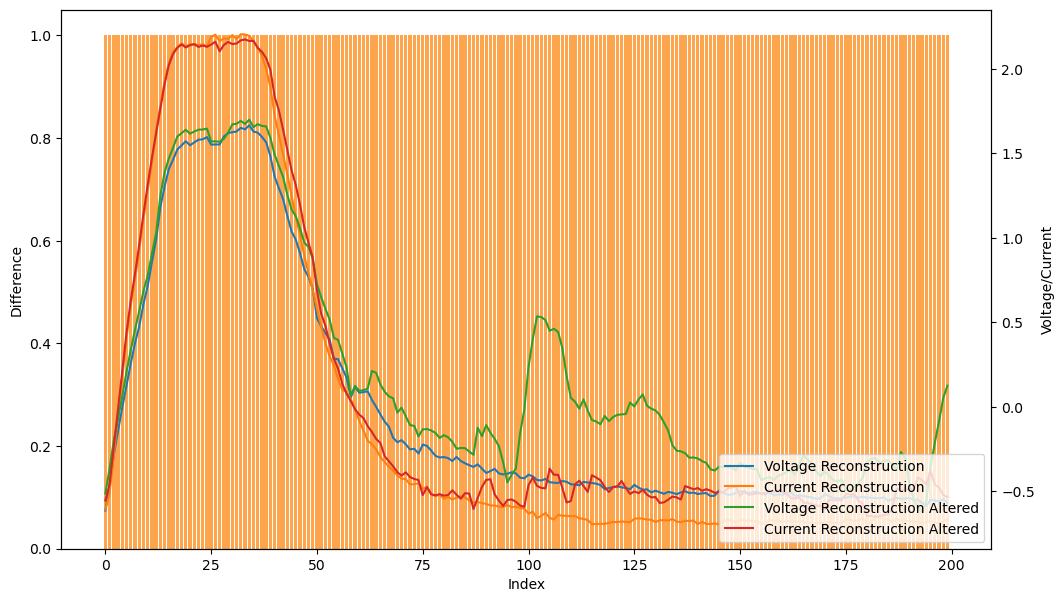

0 199


In [75]:
test_pe = current_model["model"].patch_embed
original_data = torch.from_numpy(train_data[0]).float()

def plot_reconstruction_difference_v4(reconstructed_original, reconstructed_changed, original, label, plot_original=False):
    difference = torch.sum(torch.abs(reconstructed_original - reconstructed_changed), dim=1)
    difference_extreme = torch.where(difference > 0, 1.0, 0.0).clone().detach()
    difference = difference.detach().numpy()
    difference_extreme = difference_extreme.detach().numpy()
    colormap = plt.colormaps['Wistia']
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 7)
    ax2 = ax.twinx()
    ax.set_xlabel('Index')
    ax.set_ylabel('Difference')
    ax2.set_ylabel('Voltage/Current')
    ax2.plot(reconstructed_original.detach().numpy())
    ax2.plot(reconstructed_changed.detach().numpy())
    ax2.legend(['Voltage Reconstruction', 'Current Reconstruction', 'Voltage Reconstruction Altered', 'Current Reconstruction Altered'], loc='lower right')
    bars = ax.bar(np.arange(len(reconstructed_original)), [1] * len(reconstructed_original), color=colormap(difference_extreme), alpha=0.7)
    plt.show()
    return difference

print(f"Original Data: ",original_data.unsqueeze(0).shape)
# test_out = current_model["model"](original_data.unsqueeze(0))
orig_alt = original_data.clone()
orig_alt[120:130,:] = 1.50
test_x = current_model["model"].patch_embed(original_data.unsqueeze(0))
print(f"After Patch Embed: ",test_x.shape)
test_x_alt = current_model["model"].patch_embed(orig_alt.unsqueeze(0))
# test_x_alt[0,:,0] = 0.00
# print(torch.eq(test_x,test_x_alt))
test_ze = current_model["model"].encoder(test_x)
test_ze_alt = current_model["model"].encoder(test_x_alt)
print(f"After encoder: ",test_ze.shape)
_,test_zq,_,_,indices = current_model["model"].vector_quantization(test_ze)
_,test_zq_alt,_,_,indices_alt = current_model["model"].vector_quantization(test_ze_alt)
print(f"After VQ: ",test_zq.shape)
test_zq_perm = test_zq.permute(0,2,1)
test_zq_perm_alt = test_zq_alt.permute(0,2,1)
print(f"Before decoder: ",test_zq_perm.shape)
test_xhat = current_model["model"].decoder(test_zq_perm)
test_xhat_alt = current_model["model"].decoder(test_zq_perm_alt)
# test_xhat_alt[0,:,15] = 0.00
# test_xhat_alt = test_xhat_alt.permute(0,2,1)

print(f"After decoder: ",test_xhat.shape)
test_out = current_model["model"].reverse_patch_embed(test_xhat)
test_out_alt = current_model["model"].reverse_patch_embed(test_xhat_alt)
print(f"After Reverse Patch: ",test_out.shape)
_, original_out, _ = current_model["model"](original_data.unsqueeze(0))
print(f"Original Out: ",original_out.shape)

difference = plot_reconstruction_difference_v4(reconstructed_original=original_out[0], reconstructed_changed=test_out_alt[0], original=original_data, label="label", plot_original=False)
my_difference = np.where(difference > 0)[0]
if len(my_difference) > 0:
    print(np.where(difference > 0)[0][0], np.where(difference > 0)[0][-1])

In [76]:
from pprint import pprint
# INPUT
# torch.eq(original_data, orig_alt)
# print(orig_alt.shape)
# PATCH EMBEDDING
# torch.eq(test_x,test_x_alt)[0]
# print(test_x.shape)
# ENCODER OUTPUT
# torch.eq(test_ze, test_ze_alt)[0][8]


# VQ OUTPUT
torch.eq(test_zq, test_zq_alt)[0][0]
# print(test_zq)
pprint(list(np.array(indices.reshape(16))))
pprint(list(np.array(indices_alt.reshape(16))))
# DECODER OUTPUT
# torch.eq(test_xhat, test_xhat_alt)[0]
# test_xhat.shape
# REVERSE PATCH EMBEDDING
# torch.eq(test_out, test_out_alt)
# print(orig_alt)
# pprint(test_zq[0][0])
# pprint(test_zq_alt[0][0])

[172, 197, 177, 80, 80, 80, 80, 80, 32, 197, 177, 80, 217, 217, 217, 217]
[172, 197, 177, 80, 163, 106, 80, 80, 32, 197, 177, 80, 163, 106, 217, 217]


In [26]:
proj = nn.Conv1d(1, 32, kernel_size=16, stride=16)
x = original_data.unsqueeze(0)
# print(x[0][:20])
x = x.permute(0, 2, 1)
print(x.shape)
print(x[0][1][:20])
x = x.reshape(x.shape[0], -1).unsqueeze(1)
print(x.shape)
x = proj(x)
print(x.shape)


torch.Size([1, 2, 200])
tensor([-0.6521, -0.5130, -0.2828, -0.0458,  0.1822,  0.3970,  0.5989,  0.7843,
         0.9625,  1.1427,  1.3141,  1.4863,  1.6434,  1.7927,  1.9317,  2.0609,
         2.1608,  2.2173,  2.2313,  2.2264])
torch.Size([1, 1, 400])
torch.Size([1, 32, 25])


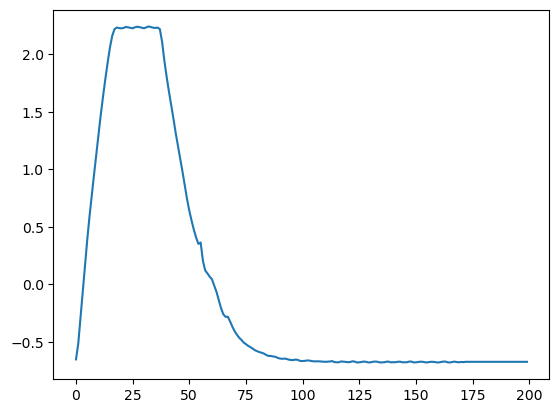

In [32]:
plt.plot(original_data[:,1].numpy())

In [85]:
test_x = test_pe(original_data.unsqueeze(0))
test_x.shape

torch.Size([1, 32, 16])

In [95]:
test_x

tensor([[[ 3.4224e-01,  0.0000e+00,  6.8542e-01, -2.1705e-01, -2.1257e-01,
          -2.2159e-01, -2.1429e-01, -2.2192e-01,  5.9906e-01,  4.7120e-01,
          -1.9329e-01, -2.5064e-01, -2.4699e-01, -2.4588e-01, -2.4610e-01,
          -2.4621e-01],
         [ 4.1554e-01,  0.0000e+00,  1.5944e+00,  1.0244e-02, -2.2953e-02,
          -3.3360e-02, -2.7340e-02, -3.1200e-02,  5.9845e-01,  9.5605e-01,
           1.2406e-01, -4.6163e-02, -5.6523e-02, -5.7131e-02, -5.6942e-02,
          -5.6374e-02],
         [-5.1575e-01,  0.0000e+00, -5.0326e-02,  6.4861e-02,  2.7023e-02,
           3.1595e-02,  2.8232e-02,  3.1674e-02, -7.4941e-01, -1.4245e-01,
           1.4011e-01,  6.2301e-02,  4.6492e-02,  4.4802e-02,  4.5557e-02,
           4.4868e-02],
         [-4.4252e-02,  0.0000e+00,  1.3908e+00, -2.4817e-01, -3.6629e-01,
          -3.9070e-01, -3.8451e-01, -3.8942e-01,  3.6482e-02,  1.3295e+00,
           1.0654e-01, -3.8701e-01, -4.3670e-01, -4.4081e-01, -4.4050e-01,
          -4.3936e-01],
    

In [94]:
test_x[0,:,1] = 0.00

In [96]:
test_ze = current_model["model"].encoder(test_x)
test_ze.shape

torch.Size([1, 16, 64])

In [97]:
_,test_zq,_,_,_ = current_model["model"].vector_quantization(test_ze)
test_zq.shape

torch.Size([1, 16, 64])

In [98]:
test_zq = test_zq.permute(0,2,1)

In [99]:
test_xhat = current_model["model"].decoder(test_zq)
print(test_xhat.shape)

torch.Size([1, 32, 16])


In [90]:
test_out = current_model["model"].reverse_patch_embed(test_xhat)
print(test_out.shape)

torch.Size([1, 200, 2])


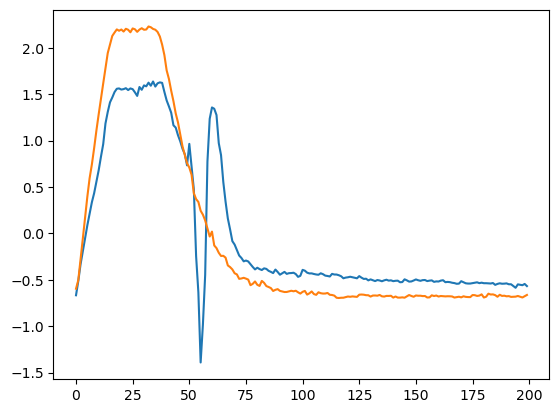

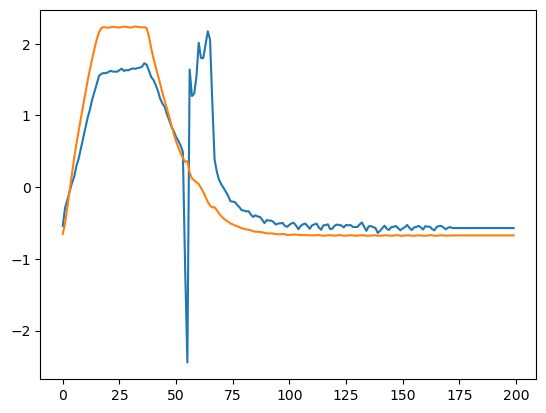

In [100]:
test_pe = current_model["model"].patch_embed
original_data = torch.from_numpy(train_data[3]).float()

# _, test_out, _ = current_model["model"](original_data.unsqueeze(0))
plt.plot(test_out[0].detach().numpy())
plt.show()
# original_data[:50] = 0.0
# _, test_out, _ = current_model["model"](original_data.unsqueeze(0))
# plt.plot(test_out[0].detach().numpy())
# plt.show()
plt.plot(original_data.detach().numpy())